# Bibliografía
- https://poloclub.github.io/cnn-explainer/ - CNN explainer
- https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch - Modelo CNN de ejemplo
- Modelo preentrenado



In [ ]:
import cv2
import os

def recortar_imagen(input_folder, output_folder, crop_width=550, crop_height=550, threshold_value=225):
    """
    Recorta imágenes de huellas dactilares centradas en el contorno más grande detectado.

    Args:
        input_folder (str): Carpeta con imágenes de entrada.
        output_folder (str): Carpeta donde se guardarán las imágenes recortadas.
        crop_width (int): Ancho del recorte deseado.
        crop_height (int): Altura del recorte deseado.
        threshold_value (int): Umbral para binarización (grises).
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if not file.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar tipos de imagen
                continue

            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Error al leer la imagen {img_path}")
                continue

            # Binarización de la imagen
            _, thresh = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)

            # Encontrar contornos
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Seleccionar el contorno más grande
                largest_contour = max(contours, key=cv2.contourArea)

                # Calcular la caja delimitadora
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Calcular el centro del contorno
                center_x, center_y = x + w // 2, y + h // 2

                # Determinar las coordenadas del recorte
                x_start = max(center_x - crop_width // 2, 0)
                y_start = max(center_y - crop_height // 2, 0)
                x_end = min(center_x + crop_width // 2, img.shape[1])
                y_end = min(center_y + crop_height // 2, img.shape[0])

                # Ajustar el tamaño del recorte si es necesario
                if (x_end - x_start) != crop_width:
                    x_start = max(0, x_end - crop_width)
                if (y_end - y_start) != crop_height:
                    y_start = max(0, y_end - crop_height)

                # Realizar el recorte
                cropped_img = img[y_start:y_end, x_start:x_end]

                # Guardar la imagen recortada
                output_path = os.path.join(output_folder, file)
                cv2.imwrite(output_path, cropped_img)
                print(f"Imagen recortada guardada en {output_path}")

# Uso del método
input_folder = 'imagenes_huellas'   # Directorio de imágenes de entrada
output_folder = 'imagenes_recortadas'  # Directorio donde se guardarán las imágenes recortadas

recortar_imagen(input_folder, output_folder)


In [ ]:
import cv2
import numpy as np
import os

def procesar_imagen(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: No se pudo cargar la imagen {image_path}.")
        return
    
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image)
    
    bilateral_filtered = cv2.bilateralFilter(equalized_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    median_filtered = cv2.medianBlur(bilateral_filtered, 3)
    
    thresh_image = cv2.adaptiveThreshold(
        median_filtered,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        19,
        3
    )
    
    inverted_image = cv2.bitwise_not(thresh_image)
    
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    
    skeleton = np.zeros(cleaned_image.shape, np.uint8)
    img = cleaned_image.copy()
    while True:
        eroded = cv2.erode(img, None)
        temp = cv2.dilate(eroded, None)
        temp = cv2.subtract(img, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break

    cv2.imwrite(output_path, skeleton)
    print(f"Imagen procesada y guardada en {output_path}")



input_dir = 'imagenes_recortadas'
output_dir = 'imagenes_filtradas'

os.makedirs(output_dir, exist_ok=True)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.png'):
            image_path = os.path.join(root, file)
            output_path = os.path.join(output_dir, file)

            procesar_imagen(image_path, output_path)

## Codigo de david

## Estrucutra de datos imagenes

In [1]:
import os
import shutil

# Directorio de entrada
input_dir = 'imagenes_filtradas'

# Directorios de salida
output_dir = 'data'
os.makedirs(os.path.join(output_dir, 'train/authenticated'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/rejected'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/authenticated'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/rejected'), exist_ok=True)

# Separar imágenes de acuerdo a su sufijo
train_images = [img for img in os.listdir(input_dir) if 'f' in img]
test_images = [img for img in os.listdir(input_dir) if 's' in img]

# Etiquetar como autenticadas o rechazadas
for idx, image in enumerate(train_images):
    if idx < len(train_images) // 2:  # La mitad serán autenticadas
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'train/authenticated', image))
    else:  # La otra mitad serán rechazadas
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'train/rejected', image))

for idx, image in enumerate(test_images):
    if idx < len(test_images) // 2:  # La mitad serán autenticadas
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'test/authenticated', image))
    else:  # La otra mitad serán rechazadas
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'test/rejected', image))

print("Estructura creada con éxito.")


Estructura creada con éxito.


## Aumento del numero de huellas (muestras)

In [2]:
import os
import cv2
import random
import numpy as np

def new_images(input_dir, num_images):
    images = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    
    for image_name in images:
        image_path = os.path.join(input_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        for i in range(num_images):
            img_copy = img.copy()
            
            # Rotación aleatoria
            angle = random.randint(-90, 90)
            h, w = img_copy.shape
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented_img = cv2.warpAffine(img_copy, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Escalado aleatorio
            scale_x = random.uniform(0.5, 1.2)
            scale_y = random.uniform(0.5, 1.2)
            augmented_img = cv2.resize(augmented_img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            
            #if input_dir.endswith('rejected'):
            # Corte parcial (simulando mal contacto)
            x1, y1 = random.randint(0, w // 8), random.randint(0, h // 8)
            x2, y2 = random.randint(x1, w // 4), random.randint(y1, h // 4)
            cv2.rectangle(augmented_img, (x1, y1), (x2, y2), (0, 0, 0), -1)
                
            # Traslación aleatoria
            max_shift = 10  # Máximo desplazamiento en píxeles
            tx = random.randint(-max_shift, max_shift)
            ty = random.randint(-max_shift, max_shift)
            translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
            augmented_img = cv2.warpAffine(augmented_img, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Guardar imagen aumentada en el mismo directorio
            output_name = f"{i}_{image_name}"
            cv2.imwrite(os.path.join(input_dir, output_name), augmented_img)

# Directorios de train y test
train_authenticated_dir = 'data/train/authenticated'
test_authenticated_dir = 'data/test/authenticated'
train_rejected_dir = 'data/train/rejected'
test_rejected_dir = 'data/test/rejected'

for directory in [train_authenticated_dir, test_authenticated_dir, train_rejected_dir, test_rejected_dir]:
        new_images(directory, num_images=10)


## Etiquetamos las huellas

In [3]:
import test
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image


# Transformaciones para entrenamiento (con data augmentation dinámico)
train_transform = transforms.Compose([
    transforms.Grayscale(),  # Convertir a escala de grises
    transforms.Resize((224, 224)),  # Redimensionar a 128x128
    transforms.RandomRotation(degrees=360),  # Rotación aleatoria entre -360 y 360 grados
    transforms.RandomHorizontalFlip(p=0.5),  # Volteo horizontal con probabilidad 50%
    transforms.RandomVerticalFlip(p=0.5),  # Volteo vertical con probabilidad 50%
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Traslación aleatoria (10% en ambas direcciones)
    transforms.RandomPerspective(distortion_scale=0.2, p=0.25),  # Perspectiva aleatoria
    transforms.ToTensor(),  # Convertir a tensor
    #transforms.RandomErasing(p=0.25, scale=(0.01, 0.1), ratio=(0.5, 2.0)),
    transforms.Normalize((0.5,), (0.5,))  # Normalización
])

test_transform = transforms.Compose([
    transforms.Grayscale(),  # Convertir a escala de grises
    transforms.Resize((224, 224)),  # Redimensionar
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización
])



# Dataset personalizado
class FingerprintDataset(Dataset):
    def __init__(self, directory, transform):
        self.transform = transform
        self.data = []

        # Leer las imágenes y sus etiquetas según las subcarpetas
        for label, subfolder in enumerate(['authenticated', 'rejected']):
            subfolder_path = os.path.join(directory, subfolder)
            if os.path.exists(subfolder_path):  # Verificar que la subcarpeta exista
                for img_name in os.listdir(subfolder_path):
                    if img_name.endswith('.png'):
                        img_path = os.path.join(subfolder_path, img_name)
                        self.data.append((img_path, label))  # Añadir la ruta de la imagen y la etiqueta

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        return image, label


# Cargar datasets
train_dataset = FingerprintDataset(directory='data/train', transform=train_transform)
test_dataset = FingerprintDataset(directory='data/test', transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Verificar las etiquetas en el DataLoader
for images, labels in train_loader:
    print(images.shape)  # Dimensiones del lote de imágenes
    print(labels)  # Etiquetas: 0 (autenticadas), 1 (rechazadas)
    break  # Mostrar solo un lote


torch.Size([16, 1, 224, 224])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])


## Modelo CNN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [5]:
import torch
import torch.nn as nn

# CNN mejorada
class FingerprintCNN(nn.Module):
    def __init__(self):
        super(FingerprintCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Bloque 1
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1 canal de entrada (grises)
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce tamaño a la mitad
            
            # Bloque 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Bloque 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Bloque 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce tamaño final
        )
        
        # Calcula el tamaño dinámico del tensor después de las convoluciones
        self._calculate_flatten_size()
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Aplanar la salida de las convoluciones
            nn.Linear(self.flattened_size, 512),  # Ajustar según el tamaño final de los mapas de características
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.5),  # Regularización
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.5),  # Regularización
            
            nn.Linear(256, 1),  # Una salida binaria
            nn.Sigmoid()  # Activación entre 0 y 1
        )
    
    def _calculate_flatten_size(self):
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, 224, 224)  # Tamaño de entrada esperado
                conv_out = self.conv_layers(dummy_input)
                self.flattened_size = conv_out.numel()  # Calcula el tamaño después de las convoluciones
        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [6]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

model = FingerprintCNN().to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss para clasificación binaria
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 

Usando dispositivo: cuda


In [7]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Poner el modelo en modo entrenamiento
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convertir etiquetas a float
        
        # Adelante
        outputs = model(images).squeeze(1)  # Eliminar dimensión extra de la salida
        loss = criterion(outputs, labels)
        
        # Atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/50, Loss: 0.7885
Epoch 2/50, Loss: 0.7820
Epoch 3/50, Loss: 0.7362
Epoch 4/50, Loss: 0.7167
Epoch 5/50, Loss: 0.7215
Epoch 6/50, Loss: 0.7014
Epoch 7/50, Loss: 0.6878
Epoch 8/50, Loss: 0.6621
Epoch 9/50, Loss: 0.6762
Epoch 10/50, Loss: 0.6314
Epoch 11/50, Loss: 0.6555
Epoch 12/50, Loss: 0.7216
Epoch 13/50, Loss: 0.6342
Epoch 14/50, Loss: 0.6471
Epoch 15/50, Loss: 0.6650
Epoch 16/50, Loss: 0.6323
Epoch 17/50, Loss: 0.6236
Epoch 18/50, Loss: 0.6394
Epoch 19/50, Loss: 0.5959
Epoch 20/50, Loss: 0.5612
Epoch 21/50, Loss: 0.6119
Epoch 22/50, Loss: 0.5539
Epoch 23/50, Loss: 0.6296
Epoch 24/50, Loss: 0.5609
Epoch 25/50, Loss: 0.5620
Epoch 26/50, Loss: 0.5360
Epoch 27/50, Loss: 0.4748
Epoch 28/50, Loss: 0.5774
Epoch 29/50, Loss: 0.5739
Epoch 30/50, Loss: 0.5571
Epoch 31/50, Loss: 0.5258
Epoch 32/50, Loss: 0.5039
Epoch 33/50, Loss: 0.5532
Epoch 34/50, Loss: 0.4742
Epoch 35/50, Loss: 0.4936
Epoch 36/50, Loss: 0.5584
Epoch 37/50, Loss: 0.5180
Epoch 38/50, Loss: 0.5086
Epoch 39/50, Loss: 0.

F1-Score: 0.6093
Accuracy en conjunto de prueba: 46.36%
Total de imágenes: 110, Correctas: 51, Incorrectas: 59


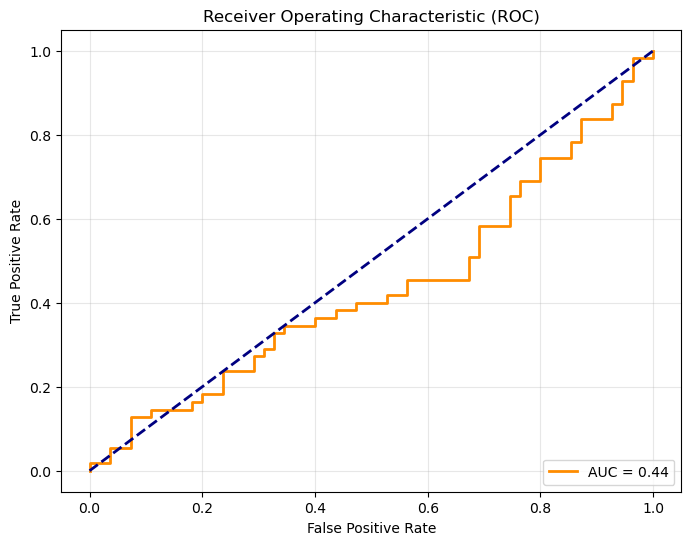

C:\Users\Acer\AppData\Local\Temp\ipykernel_20244\2700981951.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(probabilities)[np.array(labels) == 1], label='Autenticadas (1)', shade=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_20244\2700981951.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(probabilities)[np.array(labels) == 0], label='Rechazadas (0)', shade=True)


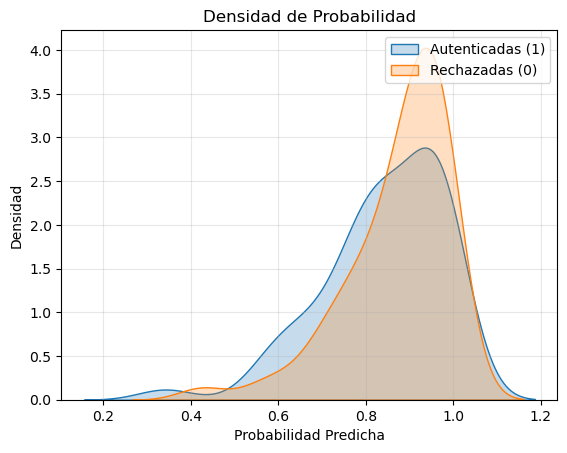

EER: 0.56 (Threshold: 0.89)


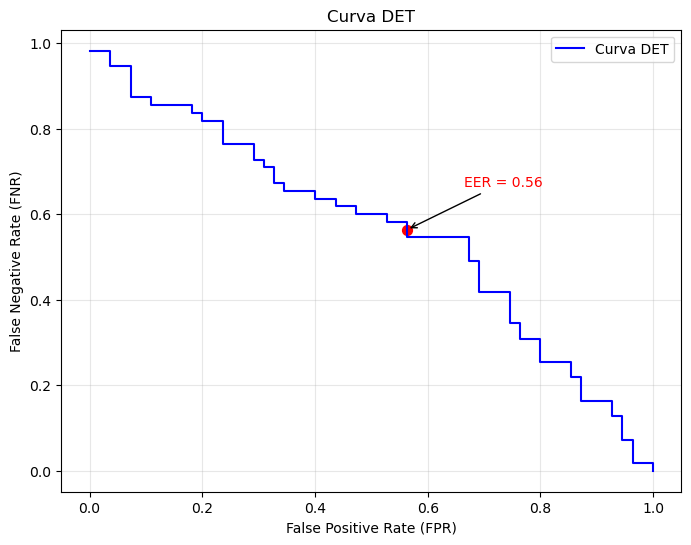

In [9]:
from sklearn.metrics import f1_score, roc_curve, auc, det_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Modo evaluación
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():  # No necesitamos gradientes para evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze(1)
        predicted = (outputs > 0.7).float()  # Umbral: salida > 0.7 es 1 (authenticated)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(outputs.cpu().numpy())

# Calcular el F1-score
f1 = f1_score(all_labels, all_predictions)
print(f"F1-Score: {f1:.4f}")

accuracy = 100 * correct / total
print(f"Accuracy en conjunto de prueba: {accuracy:.2f}%")
print(f"Total de imágenes: {total}, Correctas: {correct}, Incorrectas: {total - correct}")


def plot_roc_curve(labels, probabilities):
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea base
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curve(all_labels, all_probabilities)

# Graficar la función de densidad de probabilidad
def plot_probability_density(labels, probabilities):
    sns.kdeplot(np.array(probabilities)[np.array(labels) == 1], label='Autenticadas (1)', shade=True)
    sns.kdeplot(np.array(probabilities)[np.array(labels) == 0], label='Rechazadas (0)', shade=True)
    plt.title('Densidad de Probabilidad')
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_probability_density(all_labels, all_probabilities)

# Calcular y mostrar el EER (Equal Error Rate)
def calculate_eer(labels, probabilities):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
    print(f"EER: {eer:.2f} (Threshold: {eer_threshold:.2f})")
    return eer, eer_threshold

eer, eer_threshold = calculate_eer(all_labels, all_probabilities)

# Graficar la curva DET con el valor del EER anotado
def plot_det_curve(labels, probabilities, eer):
    fpr, fnr, _ = det_curve(labels, probabilities)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, fnr, label='Curva DET', color='blue')
    
    # Anotar el valor del EER en la gráfica
    plt.annotate(f"EER = {eer:.2f}", xy=(eer, eer), xytext=(eer + 0.1, eer + 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, color='red')
    plt.scatter(eer, eer, color='red', s=50)
    
    plt.title('Curva DET')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('False Negative Rate (FNR)')
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.show()

plot_det_curve(all_labels, all_probabilities, eer)


In [ ]:
import matplotlib.pyplot as plt
import torch

# Asegurarte de que el modelo esté en modo evaluación
model.eval()

# Obtener un lote del conjunto de entrenamiento
images, labels = next(iter(train_loader))  # Cambia `train_loader` por `test_loader` si prefieres
images, labels = images.to(device), labels.to(device)

# Realizar predicciones
with torch.no_grad():  # Desactiva el cálculo del gradiente para mayor eficiencia
    outputs = model(images).squeeze(1)  # Predicciones del modelo
    predictions = (outputs >= 0.7).float()  # Clasifica como 1 si probabilidad >= 0.7, de lo contrario 0

# Visualizar las imágenes con sus etiquetas reales y predichas
fig, axes = plt.subplots(1, 8, figsize=(16, 8))
for i, ax in enumerate(axes):
    img = images[i].cpu().squeeze().numpy()  # Convertir tensor a NumPy
    real_label = labels[i].item()  # Etiqueta real
    predicted_label = predictions[i].item()  # Etiqueta predicha
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Real: {real_label}, Pred: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


print("Etiquetas reales: ", labels.cpu().numpy())
print("Etiquetas predichas: ", predictions.cpu().numpy())


In [ ]:
from PIL import Image

# Clasificar una nueva huella
def classify_fingerprint(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('L')  # Escala de grises
    image = transform(image).unsqueeze(0).to(device)  # Añadir dimensión de batch
    with torch.no_grad():
        output = model(image).item()
    return "Authenticated" if output > 0.8 else "Rejected"

# Ruta de la nueva huella
new_fingerprint_path = 'user_prueba/huella6.png'
result = classify_fingerprint(model, new_fingerprint_path, test_transform)
print(f"Resultado de la clasificación: {result}")
